In [2]:
# We import here libraries that we'll use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split



## Gather Data

In [3]:
df = pd.read_excel(r'./../data/creditcardmarketing.xlsx') # import the excel file using a relative path to the 'data' folder

## Explore and Clean Data

In [4]:
df.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [5]:
df.shape

(18000, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer Number       18000 non-null  int64  
 1   Offer Accepted        18000 non-null  object 
 2   Reward                18000 non-null  object 
 3   Mailer Type           18000 non-null  object 
 4   Income Level          18000 non-null  object 
 5   # Bank Accounts Open  18000 non-null  int64  
 6   Overdraft Protection  18000 non-null  object 
 7   Credit Rating         18000 non-null  object 
 8   # Credit Cards Held   18000 non-null  int64  
 9   # Homes Owned         18000 non-null  int64  
 10  Household Size        18000 non-null  int64  
 11  Own Your Home         18000 non-null  object 
 12  Average Balance       17976 non-null  float64
 13  Q1 Balance            17976 non-null  float64
 14  Q2 Balance            17976 non-null  float64
 15  Q3 Balance         

In [7]:
df.isna().sum()

Customer Number          0
Offer Accepted           0
Reward                   0
Mailer Type              0
Income Level             0
# Bank Accounts Open     0
Overdraft Protection     0
Credit Rating            0
# Credit Cards Held      0
# Homes Owned            0
Household Size           0
Own Your Home            0
Average Balance         24
Q1 Balance              24
Q2 Balance              24
Q3 Balance              24
Q4 Balance              24
dtype: int64

#### **Observations:**
- column names need to be standardized
- there are some null in the account balance

In [8]:
# Clean column names
cols = [col_name.lower().replace(' ', '_') for col_name in df.columns]
df.columns = cols
df.rename(columns={'#_bank_accounts_open': 'bank_accounts_open', '#_credit_cards_held' : 'credit_cards_held', '#_homes_owned' : 'homes_owned'}, inplace=True)

In [9]:
# New dataframe to keep records with null values
df_nans = df[df.average_balance.isna()]
df_nans.head()

,customer_number,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
323,324,No,Points,Postcard,Medium,1,No,High,1,1,4,No,NaN,NaN,NaN,NaN,NaN
3070,3071,Yes,Air Miles,Postcard,Low,3,No,Medium,2,1,4,Yes,NaN,NaN,NaN,NaN,NaN
3108,3109,No,Air Miles,Letter,Low,1,No,High,3,1,4,Yes,NaN,NaN,NaN,NaN,NaN
3789,3790,No,Air Miles,Letter,Medium,2,No,High,3,1,3,No,NaN,NaN,NaN,NaN,NaN
5083,5084,No,Points,Letter,Medium,1,No,High,1,1,3,Yes,NaN,NaN,NaN,NaN,NaN


In [10]:
# Drop missing values from the dataframe to be used moving forward since it represents less than 1% of all the records
df = df[~df.average_balance.isna()]
df.shape

(17976, 17)

In [43]:
#df.to_csv(r'./../data/df_clean.csv')

In [11]:
df_target = df.copy()

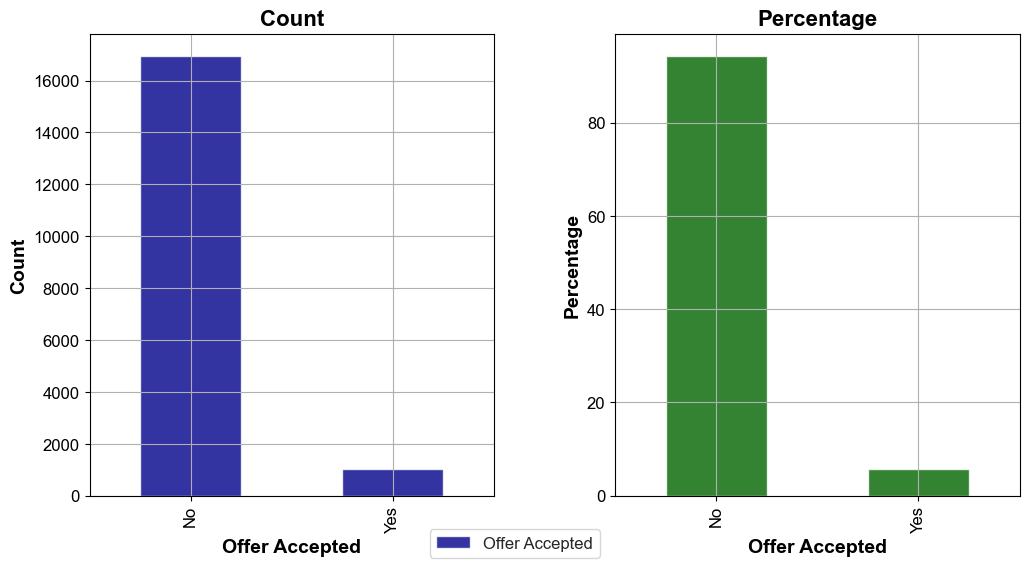

In [12]:
# Compute the count of each category
counts = df['offer_accepted'].value_counts()

# Compute the percentage of each category
percentages = df['offer_accepted'].value_counts(normalize=True) * 100

# Create a grid of two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Set the style using seaborn
sns.set_style("whitegrid")

# Plot the count of each category in the first subplot
counts.plot(kind='bar', ax=ax1, color='darkblue', alpha=0.8)
ax1.set_title('Count', fontsize=16, fontweight='bold')
ax1.set_xlabel('Offer Accepted', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=14, fontweight='bold')
ax1.tick_params(axis='both', labelsize=12)

# Plot the percentage of each category in the second subplot
percentages.plot(kind='bar', ax=ax2, color='darkgreen', alpha=0.8)
ax2.set_title('Percentage', fontsize=16, fontweight='bold')
ax2.set_xlabel('Offer Accepted', fontsize=14, fontweight='bold')
ax2.set_ylabel('Percentage', fontsize=14, fontweight='bold')
ax2.tick_params(axis='both', labelsize=12)

# Add a legend
fig.legend(labels=['Offer Accepted'], loc='lower center', ncol=1, fontsize=12)

# Add some space between the subplots
fig.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()


In [13]:
mean_balance = df['average_balance'].mean()
print(mean_balance)

940.5155624165554


In [14]:
df.describe().round(2)

,customer_number,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.00,17976.00,17976.0,17976.00,17976.00,17976.00,17976.00,17976.00,17976.00,17976.00
mean,8999.73,1.26,1.9,1.20,3.50,940.52,910.45,999.39,1042.03,810.19
std,5196.96,0.47,0.8,0.43,1.11,350.30,620.08,457.40,553.45,559.00
min,1.00,1.00,1.0,1.00,1.00,48.25,0.00,0.00,0.00,0.00
25%,4498.75,1.00,1.0,1.00,3.00,787.50,392.75,663.00,633.00,363.00
50%,9000.50,1.00,2.0,1.00,3.00,1007.00,772.00,1032.00,945.50,703.00
75%,13501.25,1.00,2.0,1.00,4.00,1153.25,1521.00,1342.00,1463.00,1212.00
max,18000.00,3.00,4.0,3.00,9.00,3366.25,3450.00,3421.00,3823.00,4215.00


### Numerical Variables

In [15]:
numericals = df.select_dtypes(np.number)
numericals.head()

,customer_number,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,1,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0
1,2,1,2,2,5,147.25,39.0,106.0,78.0,366.0
2,3,2,2,1,2,276.50,367.0,352.0,145.0,242.0
3,4,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0
4,5,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0


In [16]:
# check if average_balance is corresponds to the average of the 4 quarters balance
balance_check = numericals.iloc[:, -4:]
balance_check['avg'] = balance_check.mean(axis=1)
(balance_check.avg == numericals.average_balance).value_counts()

True    17976
Name: count, dtype: int64

**- average_balance column IS the average of all 4 quarters balance. Multicollinearity will be checked below.**

In [17]:
# Calculate the correlation matrix
corr_matrix = numericals.drop('customer_number', axis=1).corr()

In [18]:
corr_matrix.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
bank_accounts_open,1.000000,-0.001633,0.004762,0.008622,-0.003909,-0.002814,-0.007956,0.000190,-0.000356
credit_cards_held,-0.001633,1.000000,-0.002390,-0.003040,-0.003469,-0.009446,-0.007373,-0.007623,0.015362
homes_owned,0.004762,-0.002390,1.000000,0.005227,0.017967,0.013143,0.009758,0.007775,0.014775
household_size,0.008622,-0.003040,0.005227,1.000000,-0.003582,-0.005080,-0.008766,0.003633,0.000232
average_balance,-0.003909,-0.003469,0.017967,-0.003582,1.000000,0.481507,0.800285,0.752741,0.572380


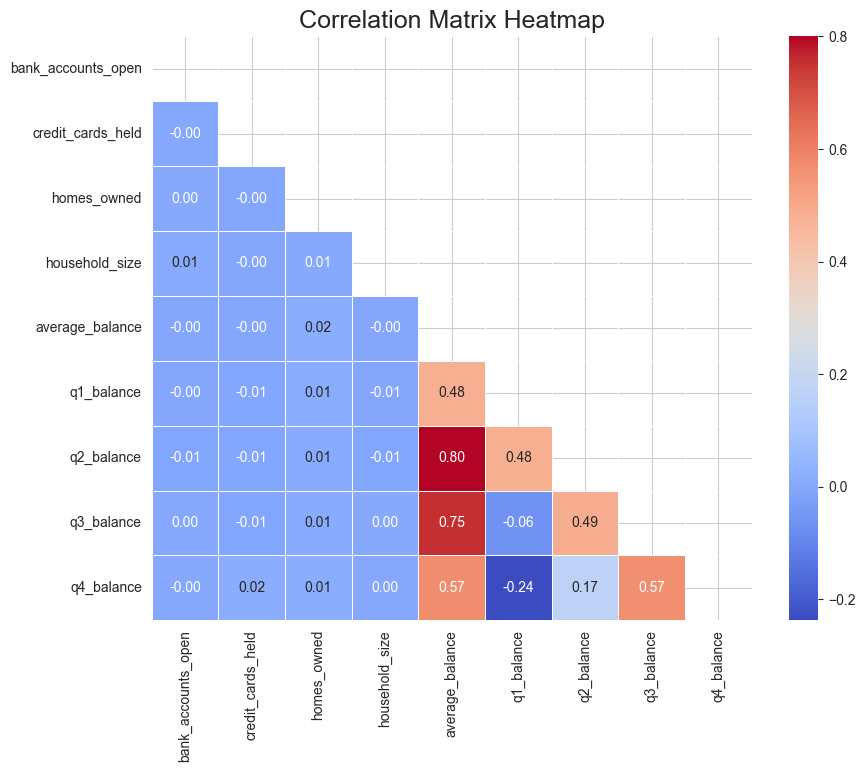

In [19]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap using the mask
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5, ax=ax)

# Add a title and adjust the margins
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.subplots_adjust(left=0.15, bottom=0.15)

# Show the plot
plt.show()

### Categorical Variables

In [20]:
cat_df = df.select_dtypes(include=['object'])

In [21]:
cat_df.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes
3,No,Air Miles,Letter,Medium,No,High,No
4,No,Air Miles,Letter,Medium,No,Medium,Yes


In [22]:
# separate target variable
y = cat_df.offer_accepted
y.value_counts()

offer_accepted
No     16955
Yes     1021
Name: count, dtype: int64

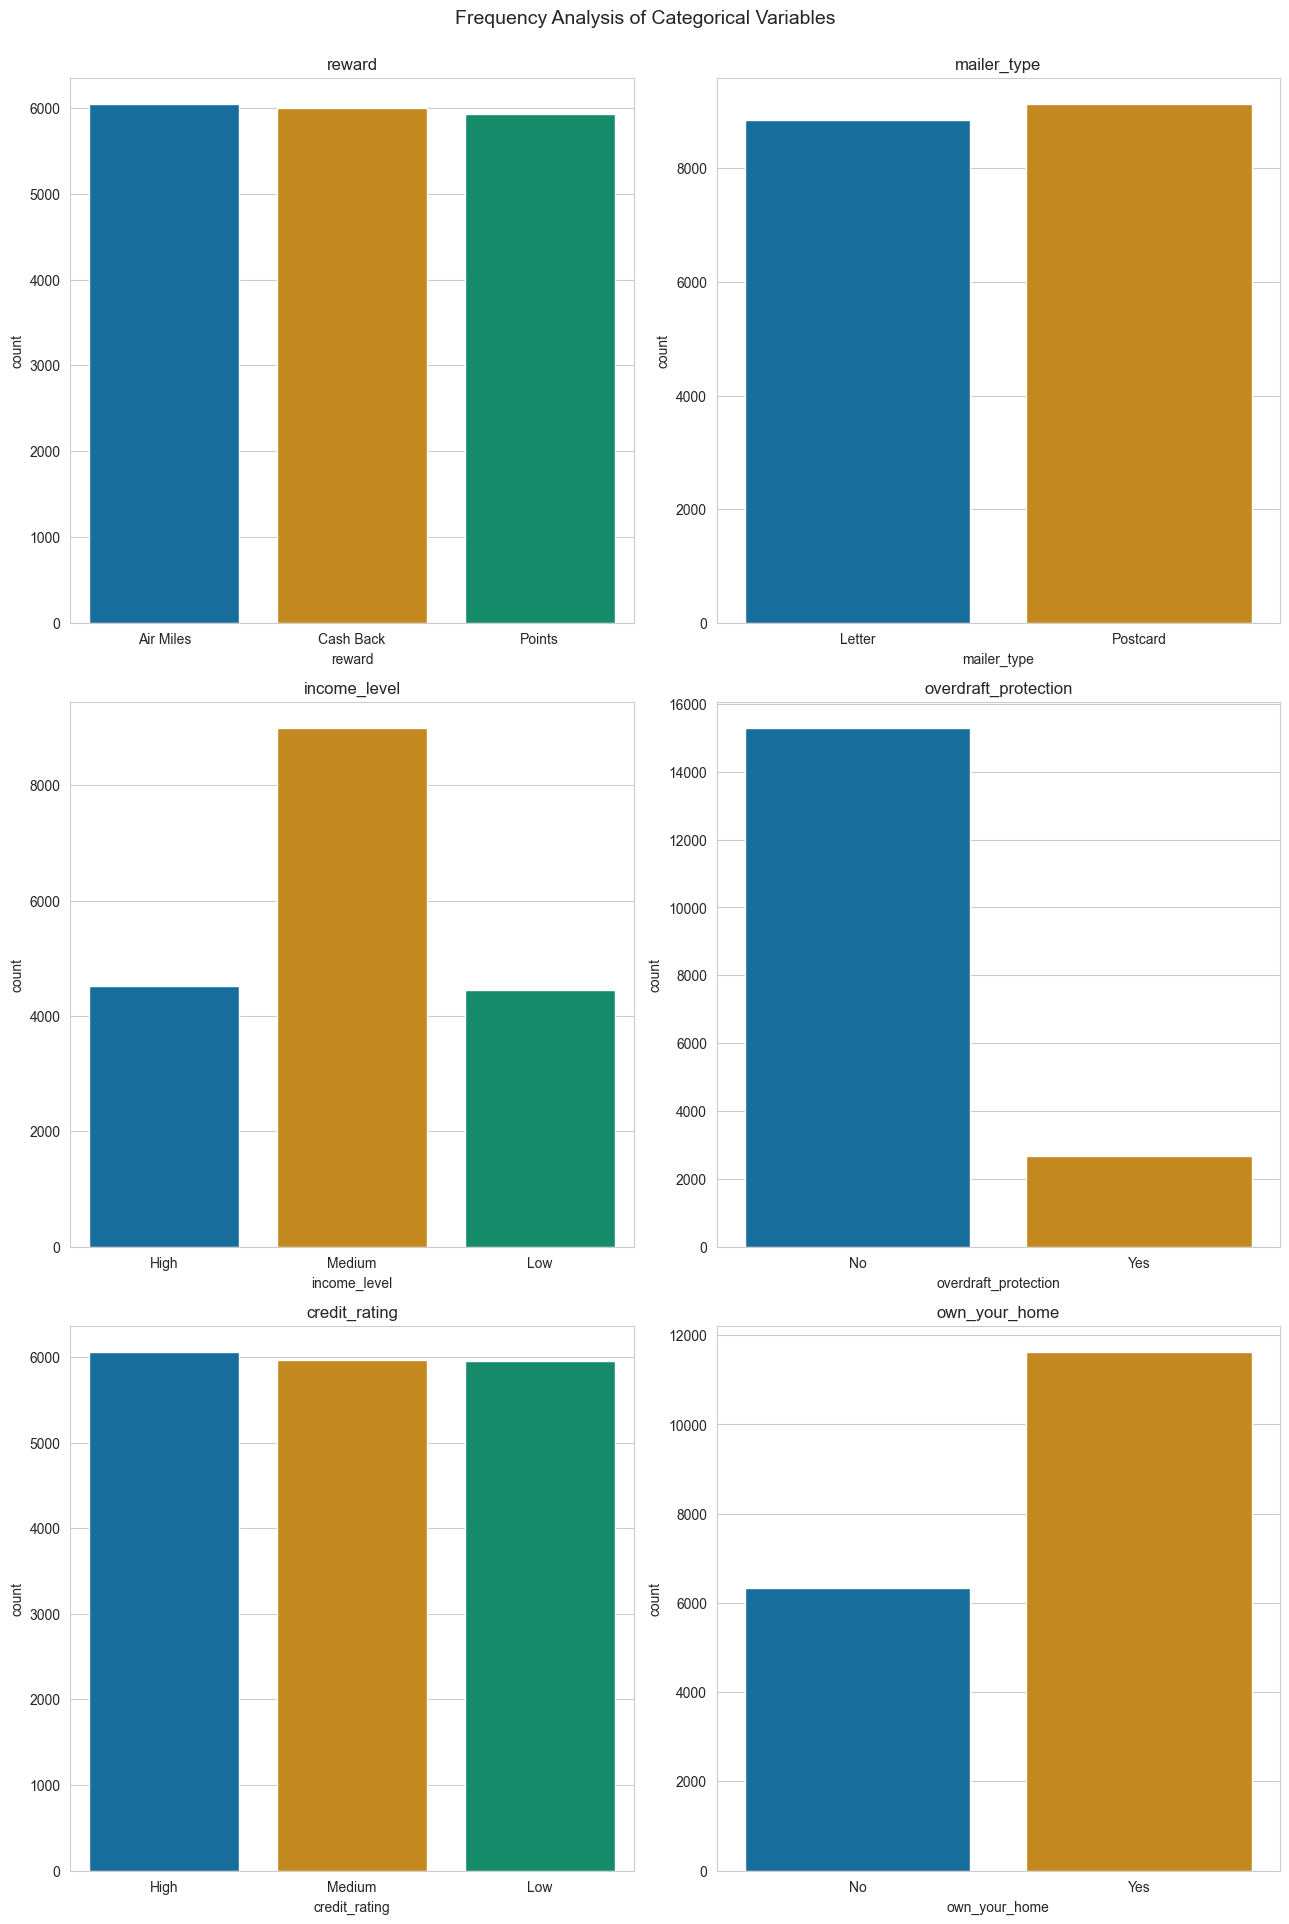

In [36]:
a = 4  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = (13,25))
plt.suptitle("Frequency Analysis of Categorical Variables", fontsize = 14, y=1)
sns.set_palette('colorblind')

for i in cat_df:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.countplot(data = cat_df, x = i)
    c = c + 1

plt.tight_layout()
plt.show()

In [23]:
cat_df.drop('offer_accepted', axis=1, inplace=True)

In [24]:
#separate ordinal from nominal categoricals
nominal = cat_df[['reward', 'mailer_type', 'overdraft_protection', 'own_your_home']]
nominal.head()

,reward,mailer_type,overdraft_protection,own_your_home
0,Air Miles,Letter,No,No
1,Air Miles,Letter,No,Yes
2,Air Miles,Postcard,No,Yes
3,Air Miles,Letter,No,No
4,Air Miles,Letter,No,Yes


In [25]:
# Use pandas get_dummies to create binary indicators for each category
encoded_df = pd.get_dummies(nominal).astype(int)
encoded_df

,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,1,0,0,1,0,1,0,1,0
1,1,0,0,1,0,1,0,0,1
2,1,0,0,0,1,1,0,0,1
3,1,0,0,1,0,1,0,1,0
4,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
17995,0,1,0,1,0,1,0,0,1
17996,0,1,0,1,0,1,0,0,1
17997,0,1,0,1,0,1,0,1,0
17998,0,1,0,1,0,1,0,0,1


In [26]:
#ordinal variables
ordinal = cat_df[['income_level', 'credit_rating']]
ordinal.head()


,income_level,credit_rating
0,High,High
1,Medium,Medium
2,High,Medium
3,Medium,High
4,Medium,Medium


In [27]:
order = {'Low' : 0, 'Medium': 1, 'High' : 2}
ordinal.income_level = ordinal.income_level.map(order)
ordinal.credit_rating = ordinal.credit_rating.map(order)

/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_2528/4229890627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal.income_level = ordinal.income_level.map(order)
/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_2528/4229890627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal.credit_rating = ordinal.credit_rating.map(order)


In [28]:
ordinal.nunique()

income_level     3
credit_rating    3
dtype: int64

In [29]:
categoricals = pd.concat([ordinal, encoded_df], axis=1)
categoricals.head()

,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,2,2,1,0,0,1,0,1,0,1,0
1,1,1,1,0,0,1,0,1,0,0,1
2,2,1,1,0,0,0,1,1,0,0,1
3,1,2,1,0,0,1,0,1,0,1,0
4,1,1,1,0,0,1,0,1,0,0,1


In [30]:
# Use pandas get_dummies to create binary indicators for each category
encoded_df.head()

# Concatenate the encoded dataframe with the original dataframe
new_df = pd.concat([df, encoded_df], axis=1)

# Drop the original categorical columns
new_df = new_df.drop(columns=cat_df.columns)

# Print the first 5 rows of the new dataframe
print(new_df.head())

   customer_number offer_accepted  bank_accounts_open  credit_cards_held   
0                1             No                   1                  2  \
1                2             No                   1                  2   
2                3             No                   2                  2   
3                4             No                   2                  1   
4                5             No                   1                  2   

   homes_owned  household_size  average_balance  q1_balance  q2_balance   
0            1               4          1160.75      1669.0       877.0  \
1            2               5           147.25        39.0       106.0   
2            1               2           276.50       367.0       352.0   
3            1               4          1219.00      1578.0      1760.0   
4            1               6          1211.00      2140.0      1357.0   

   q3_balance  q4_balance  reward_Air Miles  reward_Cash Back  reward_Points   
0      1095.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17976 entries, 0 to 17999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_number       17976 non-null  int64  
 1   offer_accepted        17976 non-null  object 
 2   reward                17976 non-null  object 
 3   mailer_type           17976 non-null  object 
 4   income_level          17976 non-null  object 
 5   bank_accounts_open    17976 non-null  int64  
 6   overdraft_protection  17976 non-null  object 
 7   credit_rating         17976 non-null  object 
 8   credit_cards_held     17976 non-null  int64  
 9   homes_owned           17976 non-null  int64  
 10  household_size        17976 non-null  int64  
 11  own_your_home         17976 non-null  object 
 12  average_balance       17976 non-null  float64
 13  q1_balance            17976 non-null  float64
 14  q2_balance            17976 non-null  float64
 15  q3_balance            17

In [32]:
X = numericals.join(categoricals)
X.drop('customer_number', axis=1, inplace=True)

In [33]:
X.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0,2,2,1,0,0,1,0,1,0,1,0
1,1,2,2,5,147.25,39.0,106.0,78.0,366.0,1,1,1,0,0,1,0,1,0,0,1
2,2,2,1,2,276.50,367.0,352.0,145.0,242.0,2,1,1,0,0,0,1,1,0,0,1
3,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0,1,2,1,0,0,1,0,1,0,1,0
4,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0,1,1,1,0,0,1,0,1,0,0,1


In [42]:
# X and y to csv
#X.to_csv(r'./../data/X.csv', header=True, index=False)
#y.to_csv(r'./../data/y.csv', header=True, index=False)

In [35]:
from sklearn.model_selection import train_test_split

X = encoded_df.drop('offer_accepted', axis=1)
y = encoded_df['offer_accepted']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


KeyError: "['offer_accepted'] not found in axis"